In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
from sklearn.metrics import auc
import os
import numpy as np
import pandas as pd 
import awkward as ak 
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
input_folder = "/eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron/ntuples/"

In [ ]:
f = uproot.open(file)
t =  f["ticlNtuplizer/tracksters"]
calo = f["ticlNtuplizer/simtrackstersCP"]
ass = f["ticlNtuplizer/associations"]

In [ ]:
ass.keys()

In [353]:
calo.keys()

['stsCP_event',
 'stsCP_NClusters',
 'stsCP_NTracksters',
 'stsCP_time',
 'stsCP_timeError',
 'stsCP_regressed_energy',
 'stsCP_raw_energy',
 'stsCP_raw_em_energy',
 'stsCP_raw_pt',
 'stsCP_raw_em_pt',
 'stsCP_barycenter_x',
 'stsCP_barycenter_y',
 'stsCP_barycenter_z',
 'stsCP_trackster_barycenter_eta',
 'stsCP_trackster_barycenter_phi',
 'stsCP_EV1',
 'stsCP_EV2',
 'stsCP_EV3',
 'stsCP_eVector0_x',
 'stsCP_eVector0_y',
 'stsCP_eVector0_z',
 'stsCP_sigmaPCA1',
 'stsCP_sigmaPCA2',
 'stsCP_sigmaPCA3',
 'stsCP_id_probabilities',
 'stsCP_vertices_indexes',
 'stsCP_vertices_x',
 'stsCP_vertices_y',
 'stsCP_vertices_z',
 'stsCP_vertices_energy',
 'stsCP_vertices_correctedEnergy',
 'stsCP_vertices_correctedEnergyUncertainty',
 'stsCP_vertices_multiplicity']

In [194]:
t.keys()

['event',
 'NClusters',
 'NTracksters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'trackster_barycenter_eta',
 'trackster_barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity',
 'layer_cluster_seed']

In [ ]:
import glob

files = glob.glob(f"{input_folder}/ntuples_13723002_*.root")

calos = [ ]
tracksters = [ ]
associations = [ ]

i = 0
N = 10000000
for file in files:
    if i >= N: break
    i+=1
    try:
        print('.', end="")
        f = uproot.open(file)
        t =  f["ticlNtuplizer/tracksters"]
        calo = f["ticlNtuplizer/simtrackstersCP"]
        ass = f["ticlNtuplizer/associations"]
        calos.append(calo.arrays(["stsCP_trackster_barycenter_eta","stsCP_trackster_barycenter_phi",
                                  "stsCP_barycenter_x","stsCP_barycenter_y","stsCP_barycenter_z","stsCP_raw_energy"]))
        tracksters.append(t.arrays(["raw_energy","raw_em_energy", "trackster_barycenter_eta","trackster_barycenter_phi",
                                    "barycenter_x","barycenter_y","barycenter_z","id_probabilities",
                                    "EV1", "EV2", "EV3", "eVector0_x", "eVector0_y","eVector0_z", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"]))
        associations.append(ass.arrays([ "tsCLUE3D_recoToSim_CP", "tsCLUE3D_recoToSim_CP_score"]))
    except:
        print("error ", file)
        
df_calo = ak.concatenate(calos)
df_track = ak.concatenate(tracksters)
df_ass = ak.concatenate(associations)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [271]:
EM_mask = ((df_track.id_probabilities[:,:,0] + df_track.id_probabilities[:,:,1])> 0.5) | ((df_track.raw_em_energy / df_track.raw_energy ) > 0.9)
df_track_EM = df_track[EM_mask]

(array([ 4058.,   246.,   333.,   376.,   395.,   412.,   481.,   536.,
          567.,   569.,   578.,   563.,   577.,   571.,   530.,   506.,
          480.,   471.,   518.,   485.,   530.,   559.,   528.,   581.,
          605.,   679.,   672.,   798.,   862.,   978.,  1163.,  1351.,
         1844.,  2425.,  3261.,  4642.,  5655.,  6971., 18938., 34639.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 [<matplotlib.patches.Polygon at 0x7f7205d37610>])

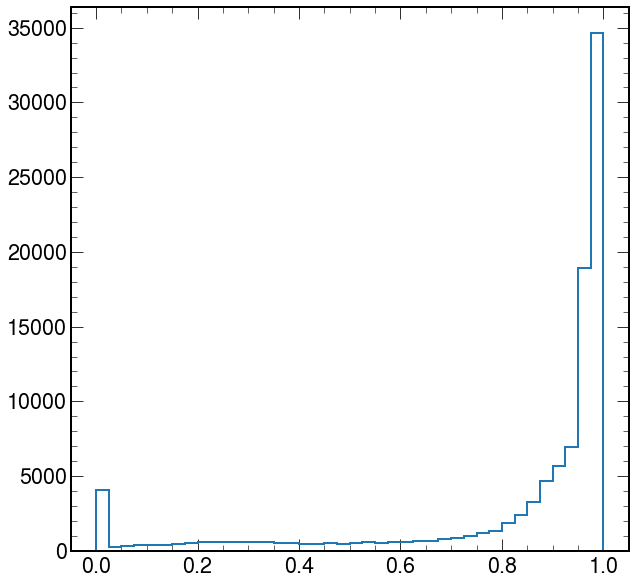

In [272]:
plt.hist(ak.flatten(df_track.id_probabilities[:,:,0]+df_track.id_probabilities[:,:,1]), bins=40, range=(0,1), linewidth=2, histtype='step' )
#plt.legend()

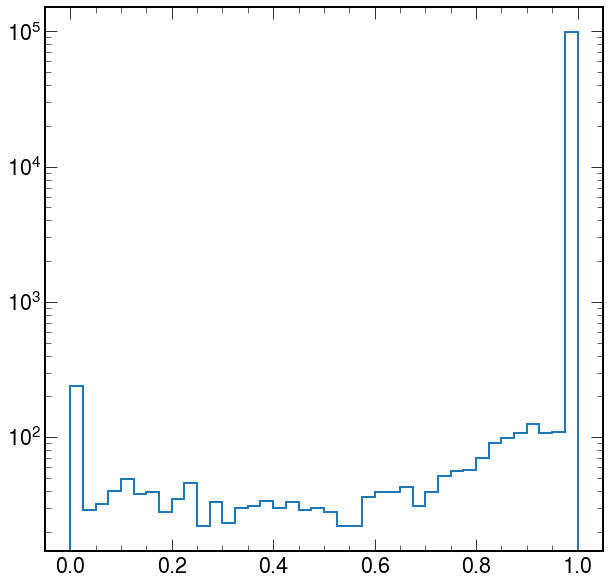

In [274]:
plt.hist(ak.flatten(df_track.raw_em_energy / df_track.raw_energy), bins=40, range=(0,1), linewidth=2, histtype='step' )
plt.yscale("log")
#plt.legend()

In [275]:
ak.num(df_track.trackster_barycenter_eta[EM_mask])

<Array [11, 4, 3, 5, 8, 11, ... 4, 3, 4, 3, 5] type='15000 * int64'>

In [276]:
ak.num(df_calo.stsCP_trackster_barycenter_eta)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='15000 * int64'>

Text(0, 1, 'phi')

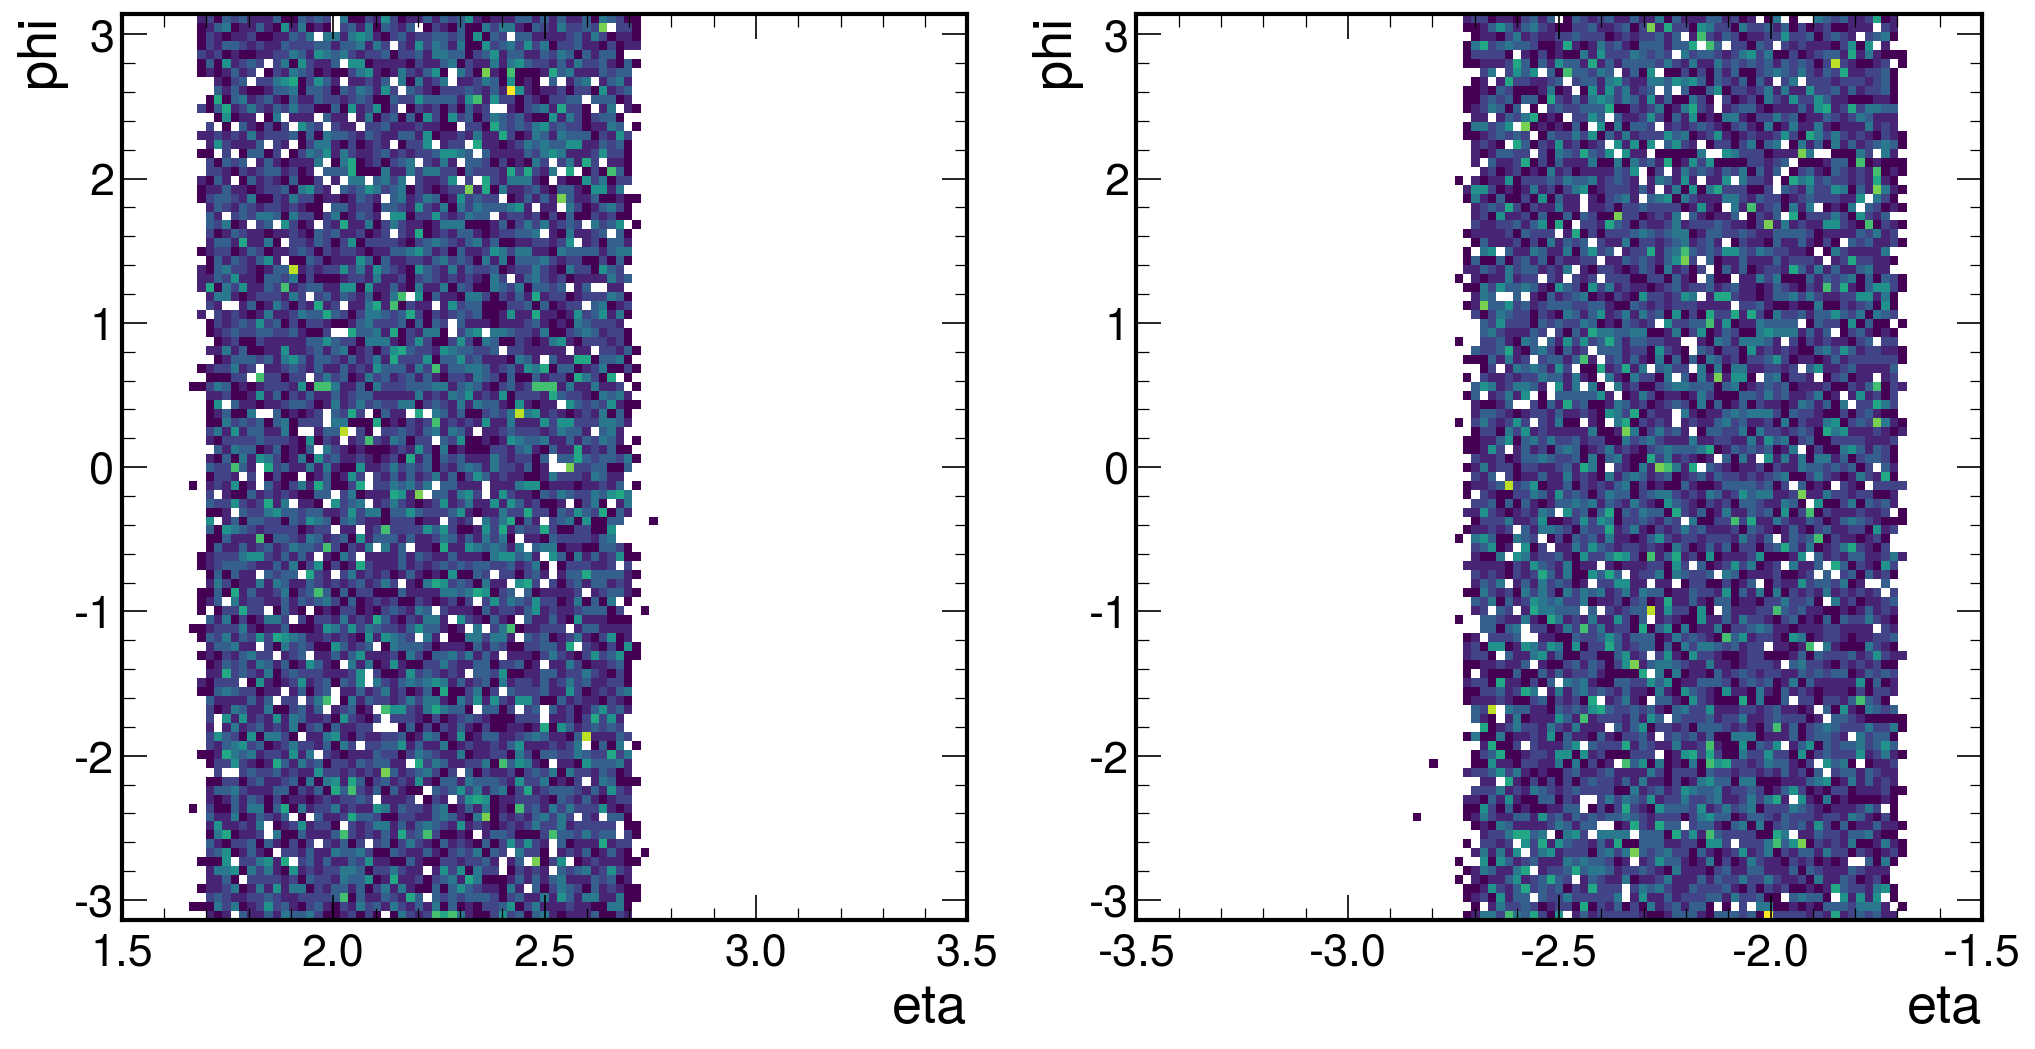

In [277]:
f, ax = plt.subplots(1,2, figsize=(16,8), dpi=150)

zmaskP = df_calo.stsCP_trackster_barycenter_eta > 0 
zmaskM = df_calo.stsCP_trackster_barycenter_eta < 0 

ax[0].hist2d(np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((1.5,3.5),(-3.14,3.14)), cmin=1)
ax[0].set_xlabel("eta")
ax[0].set_ylabel("phi")

ax[1].hist2d(np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((-3.5,-1.5),(-3.14,3.14)), cmin=1)
ax[1].set_xlabel("eta")
ax[1].set_ylabel("phi")


In [278]:
def in_window_nonumba(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z, builder):
    deta = 0.1
    dphi = 0.2
    for c_eta, c_phi, c_z, t_eta, t_phi, t_z in zip(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z):
        builder.begin_list()
        for (ceta, cphi, cz, teta,tphi, tz) in zip(c_eta, c_phi, c_z, t_eta, t_phi, t_z):
            #print(cz, tz, ceta, teta, cphi,tphi)
            same_z = np.sign(cz) == np.sign(tz)
            in_eta = abs(ceta- teta) < deta
            in_phi = abs(((cphi - tphi + np.pi) % (2 * np.pi) - np.pi)) < dphi
            builder.append(same_z & in_eta & in_phi)
        builder.end_list()
    return builder

In [279]:
import numba

@numba.njit
def in_window(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z, builder):
    deta = 0.1
    dphi = 0.2
    for c_eta, c_phi, c_z, t_eta, t_phi, t_z in zip(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z):
        builder.begin_list()
        for (ceta, cphi, cz, teta,tphi, tz) in zip(c_eta, c_phi, c_z, t_eta, t_phi, t_z):
            #print(cz, tz, ceta, teta, cphi,tphi)
            same_z = np.sign(cz) == np.sign(tz)
            in_eta = abs(ceta- teta) < deta
            in_phi = abs(((cphi - tphi + np.pi) % (2 * np.pi) - np.pi)) < dphi
            builder.append(same_z & in_eta & in_phi)
        builder.end_list()
    return builder

In [280]:
pairs = ak.argcartesian([df_calo.stsCP_trackster_barycenter_eta, df_track_EM.trackster_barycenter_eta], axis=1)

In [281]:
ak.num(df_calo.stsCP_trackster_barycenter_eta)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='15000 * int64'>

In [282]:
ak.num(df_track_EM.trackster_barycenter_eta)

<Array [11, 4, 3, 5, 8, 11, ... 4, 3, 4, 3, 5] type='15000 * int64'>

In [283]:
calo_idx, track_idx = ak.unzip(pairs)

In [284]:
df_calo.eta = df_calo.stsCP_trackster_barycenter_eta
df_calo.phi = df_calo.stsCP_trackster_barycenter_phi
df_calo.z = df_calo.stsCP_barycenter_z

df_track.eta = df_track_EM.trackster_barycenter_eta
df_track.phi = df_track_EM.trackster_barycenter_phi
df_track.z = df_track_EM.barycenter_z

In [285]:
all_calo_eta = df_calo.stsCP_trackster_barycenter_eta[calo_idx]
all_calo_phi = df_calo.stsCP_trackster_barycenter_phi[calo_idx]
all_calo_z = df_calo.stsCP_barycenter_z[calo_idx]

all_track_eta = df_track_EM.trackster_barycenter_eta[track_idx]
all_track_phi = df_track_EM.trackster_barycenter_phi[track_idx]
all_track_z = df_track_EM.barycenter_z[track_idx]

In [286]:
%%timeit
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

14.6 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [287]:
%%timeit
out = in_window_nonumba(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

9.68 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [288]:
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

In [289]:
goodpairs = pairs[out]

Now we have the pairs of caloparticle-trackers that are close in a window

In [292]:
calo_idx_inwindow, track_idx_inwindow = ak.unzip(goodpairs)

In [293]:
import numba
@numba.njit
def calo_match_mask(tcks_indices, indices_to_match,builder):
    for tr_ind, index_to_match in zip(tcks_indices, indices_to_match):
        builder.begin_list()
        #Looping other all the calolist for each trackers
        for trInd in range(len(tr_ind)):    
            calo_indices_for_this_track = tr_ind[trInd]
            #print(calo_indices_for_this_track)
            builder.begin_list()
            for i in range(len(calo_indices_for_this_track)):
                # checking if the index is the one to keep
                if i == index_to_match[trInd]:
                    builder.append(True)
                else:
                    builder.append(False)
            builder.end_list()
        builder.end_list()
    return builder

In [294]:
masked_score  = ak.mask(df_ass.tsCLUE3D_recoToSim_CP_score, df_ass.tsCLUE3D_recoToSim_CP_score<0.1)

In [295]:
armin = ak.argmin(masked_score, axis=2)
mask_for_calomatching_trackers = calo_match_mask(df_ass.tsCLUE3D_recoToSim_CP, armin, ak.ArrayBuilder())
# Apply also the EM mask on all the trackers, the index goes on top of the trackers index
trackers_to_calo = ak.flatten(df_ass.tsCLUE3D_recoToSim_CP[mask_for_calomatching_trackers], axis=-1)[EM_mask]

Now we have the caloindex of each tracker in `trackers_to_calo` and the trackers close to each calo in the `calo_idx_inwindow` and `track_idx_inwindow` arrays

In [299]:
trackers_to_calo[0:10].tolist()

[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1],
 [0, 0, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
 [0, 1, 1],
 [0, 0, 0, 1, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 1]]

In [301]:
goodpairs[0:5].tolist()

[[(0, 0), (0, 1), (0, 2), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10)],
 [(0, 0), (0, 1), (1, 2), (1, 3)],
 [(0, 0), (0, 1), (1, 2)],
 [(0, 0), (0, 1), (1, 2), (1, 3), (1, 4)],
 [(0, 2), (0, 3), (0, 4), (1, 5), (1, 6), (1, 7)]]

We now can get the indices of all the trackers close a calo 0

In [302]:
track_idx_inwindow[calo_idx_inwindow == 0][0:5].tolist()

[[0, 1, 2], [0, 1], [0, 1], [0, 1], [2, 3, 4]]

In [303]:
track_idx_inwindow[calo_idx_inwindow == 1][0:5].tolist()

[[4, 5, 6, 7, 8, 10], [2, 3], [2], [2, 3, 4], [5, 6, 7]]

Or get the **true** caloparticle matched to each trackers that is in the windo of caloparticle 0

In [304]:
true_in_window = (trackers_to_calo[   track_idx_inwindow[calo_idx_inwindow == 0] ] == 0)

### Extracting info

In [306]:
norm_PCAVect = (df_track_EM.eVector0_x **2 + df_track_EM.eVector0_y**2  + df_track_EM.eVector0_z**2)**0.5
norm_baryVect = (df_track_EM.barycenter_x **2 + df_track_EM.barycenter_y**2  + df_track_EM.barycenter_z**2)**0.5

In [307]:
norm_vect

<Array [[1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1]] type='1000 * var * float32'>

In [308]:
prod_scalar = (df_track_EM.barycenter_x * df_track_EM.eVector0_x + df_track_EM.barycenter_y * df_track_EM.eVector0_y + \
                        df_track_EM.barycenter_z * df_track_EM.eVector0_z) /(norm_PCAVect*norm_baryVect)

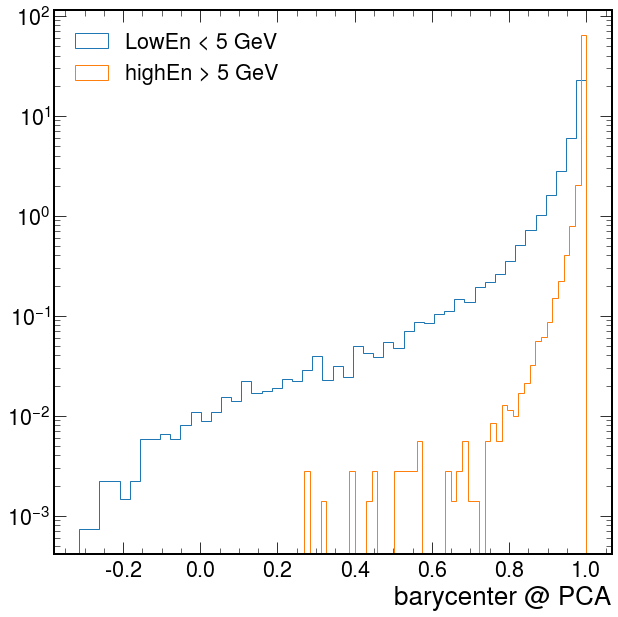

In [309]:
plt.hist(ak.flatten(prod_scalar[df_track_EM.raw_energy< 5] ), bins=50, density=True, histtype="step", label="LowEn < 5 GeV")
plt.hist(ak.flatten(prod_scalar[df_track_EM.raw_energy> 5] ), bins=50, density=True, histtype="step", label="highEn > 5 GeV")
plt.legend()
plt.xlabel("barycenter @ PCA")
plt.yscale("log")

## Write datasets

In [380]:
X = [ ]
Y = [ ] 
Y_meta = [ ]

for calo_idx in [0, 1]:
    # Get the tracksters in the window of each calo particles
    tracks_in_window = track_idx_inwindow[calo_idx_inwindow == calo_idx]
    # Get only those trackers by ID
    trk_data = df_track_EM[tracks_in_window]
    # Save the input variables
    x = ak.zip({"raw_en": trk_data.raw_energy, 
                     "barycenter_x": trk_data.barycenter_x,
                     "barycenter_y": trk_data.barycenter_y,
                     "barycenter_z": trk_data.barycenter_z,
                     "EV1": trk_data.EV1,
                     "EV2": trk_data.EV2,
                     "EV3": trk_data.EV3,
                     "sigmaPCA1": trk_data.sigmaPCA1,
                     "sigmaPCA2": trk_data.sigmaPCA2,
                     "sigmaPCA3": trk_data.sigmaPCA3,
                     "misalign":  prod_scalar[tracks_in_window],
                    }  )
    
    y  =  ak.Array(trackers_to_calo[ tracks_in_window ] == calo_idx)
    # Saving also the caloparticle metadata
    m = df_calo[:,calo_idx]
    X.append(x)
    Y.append(y)
    Y_meta.append(m)

dataset = ak.zip({"X": ak.concatenate(X, axis=0), "Y": ak.concatenate(Y, axis=0), "meta": ak.concatenate(Y_meta, axis=0)})
ak.to_parquet(dataset, "dataset.parquet")

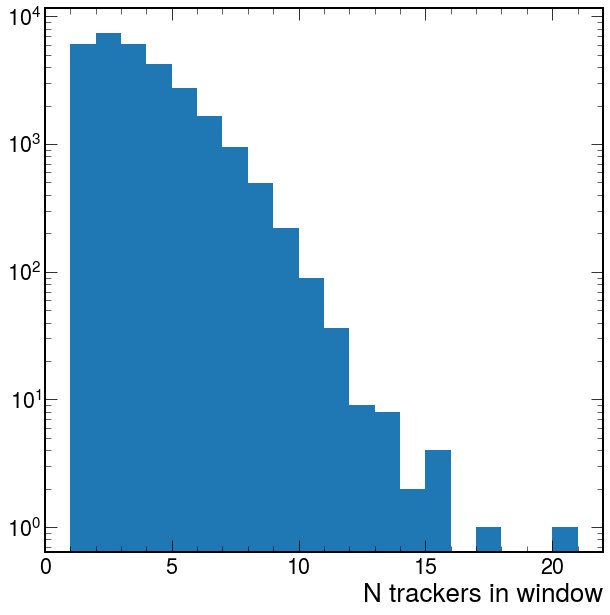

In [342]:
plt.hist(ak.num(train_data), bins=20, range=(1,21))
plt.xlabel("N trackers in window")
plt.yscale("log")

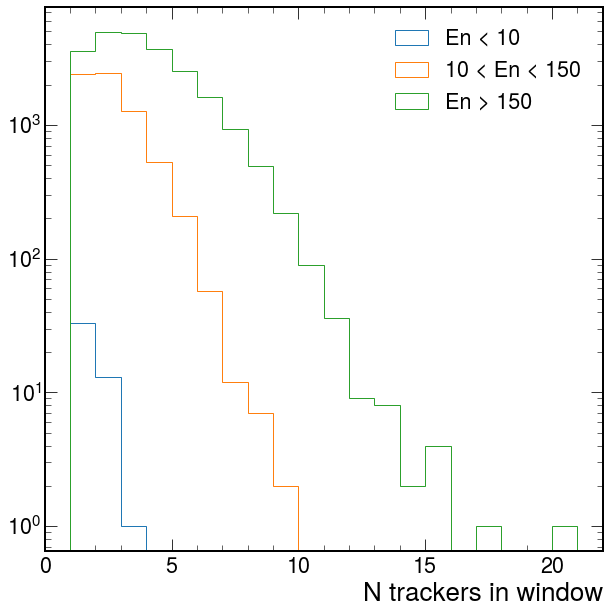

In [370]:
plt.hist(ak.num(train_data[true_metadata.stsCP_raw_energy<10]), bins=20, range=(1,21), label="En < 10", histtype="step")
plt.hist(ak.num(train_data[(true_metadata.stsCP_raw_energy>10)&(true_metadata.stsCP_raw_energy<150)]), bins=20, range=(1,21), 
         label="10 < En < 150", histtype="step")
plt.hist(ak.num(train_data[(true_metadata.stsCP_raw_energy>150)]), bins=20, range=(1,21), 
         label="En > 150", histtype="step")
plt.xlabel("N trackers in window")
plt.legend()
plt.yscale("log")